## Libraries

In [16]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import ast

%matplotlib inline
plt.style.use('seaborn')

plt.rcParams["patch.force_edgecolor"] = True
pd.set_option('display.max_rows', 200)
pd.options.mode.chained_assignment = None

## Functions

In [17]:
def load_dataset(experiment, types):
    dataset_one = pd.read_csv(f'./result_extraction/{experiment}/dataset_query_result_{types[0]}.csv', dtype=str)
    dataset_two = pd.read_csv(f'./result_extraction/{experiment}/dataset_query_result_{types[1]}.csv', dtype=str)
    
    files = os.listdir(f'./result_extraction/{experiment}')
    if not('analysis_images' in files):
        os.mkdir(f'./result_extraction/{experiment}/analysis_images')
    
    dataset_one['type'] = [types[0]]*len(dataset_one)
    dataset_two['type'] = [types[1]]*len(dataset_two)
    
    frames = [dataset_one, dataset_two]
    final_dataset = pd.concat(frames)
    
    if len(final_dataset) == (len(dataset_one) + len(dataset_two)):
        return final_dataset
    else:
        print('THERE IS A PROBLEMS...')
        return -1
    
def plot_pie_chart(dictionary_values, typology, experiment, field):
    dictionary_values = dict(sorted(dictionary_values.items()))
    title = f'{field} for: {typology}'
    bins = list(dictionary_values.keys())
    values = list(dictionary_values.values())
    colors = ['#4287f5', '#f56942', '#8a5151', '#518a5e', '#6f649c', '#a4a6b0', '#63c1d4']
    colors = colors[0:len(values)]
    fig, ax = plt.subplots()
    ax.pie(values, labels = bins, shadow=True, startangle = 90, colors = colors,
           wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%')

    ax.set_title(title)
    save_img(title, experiment)
    plt.show() 

def pie_chart(query_result, types, field, experiment):
    grp = query_result.groupby(['type'])
    dict_0 = dict(grp[field].value_counts(normalize = True).loc[types[0]])
    dict_1 = dict(grp[field].value_counts(normalize = True).loc[types[1]])
    
    if len(dict_0.keys()) < len(dict_1.keys()):
        miss_values = set(dict_1.keys()) - set(dict_0.keys())
        for miss_value in miss_values:
            dict_0[miss_value] = 0
    elif len(dict_1.keys()) > len(dict_0.keys()):
        miss_values = set(dict_0.keys()) - set(dict_1.keys())
        for miss_value in miss_values:
            dict_1[miss_value] = 0
    
    plot_pie_chart(dict_0, types[0], experiment, field)
    plot_pie_chart(dict_1, types[1], experiment, field)
    
    
def save_img(title, experiment):
    plt.savefig(f'./result_extraction/{experiment}/analysis_images/{title}.png', 
                dpi = 300, quality = 95, format = 'png', pad_inches = 1000)
    

def delete_outliers(field, df):
    values = df[field]
    removed_outliers = values.between(values.quantile(.25), values.quantile(0.75))
    index_names = df[~removed_outliers].index
    df.drop(index_names, inplace=True)
    return df
    
def violin(query_result, types, field, experiment):
    df = pd.DataFrame(columns=[f'{field}', 'type', 'placeholder'])
    for _, row in query_result.iterrows():
        df.loc[len(df)] = [row[f'{field}'], row['type'], '']
    
    df[field] = df[field].apply(lambda x: float(x))
    
    delete_outliers(field, df)
    
    plot_violin(df, types, field, experiment)
    
def plot_violin(df, types, field, experiment):
    
    fig, ax = plt.subplots()
    ax = sns.violinplot(x='placeholder', y=field, hue='type', data=df, split=True, inner='quartile', bw=0.2)
    title = f'{field.capitalize()} distribution'
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel(field)
    ax.legend()
    save_img(title, experiment)
    plt.show()
    
def distplot(query_result, types, field, experiment):
    df = pd.DataFrame(columns=[f'{field}', 'type'])
    for _, row in query_result.iterrows():
        df.loc[len(df)] = [row[f'{field}'], row['type']]
    
    df[field] = df[field].apply(lambda x: float(x))

    
    plot_distplot(df, types, field, experiment)
    
def plot_distplot(df, types, field, experiment):
    
    title = f'Distribution plot on {field}'
    type0 = df.query(f'type == "{types[0]}"')
    type1 = df.query(f'type == "{types[1]}"')
    fig, ax = plt.subplots()
    ax = sns.distplot(type0[f'{field}'], hist=False, label=f'{field} on {types[0]}')
    ax = sns.distplot(type1[f'{field}'], hist=False, label=f'{field} on {types[1]}')
    ax.set_title(title)
    ax.set_xlabel(f'{field}')
    ax.set_ylabel('Distribution')
    ax.legend()
    save_img(title, experiment)
    plt.show()
'''    
def load_data(path_food_dis, path_mental_ill):
    food_dis = pd.read_csv(path_food_dis, sep='\t', dtype=str)
    mental_ill = pd.read_csv(path_mental_ill, sep='\t', dtype=str)
    food_dis = food_dis.query("sciname != 'bacterium'")
    mental_ill = mental_ill.query("sciname != 'bacterium'")
    food_dis = food_dis[~food_dis["sciname"].str.contains("uncultured")]
    mental_ill = mental_ill[~mental_ill["sciname"].str.contains("uncultured")]
    food_dis['sciname'] = food_dis['sciname'].apply(lambda x: re.sub('[\[|\]]', '', x))
    mental_ill['sciname'] = mental_ill['sciname'].apply(lambda x: re.sub('[\[|\]]', '', x))
    
    #top 10 food illness
    sciname_f = food_dis.groupby('sciname').count()[['accession']].index
    count_f = food_dis.groupby('sciname').count()['accession'].values
    dict_sciname_f = {'sciname':sciname_f, 'accession':count_f}
    top_food_ill = pd.DataFrame(dict_sciname_f, columns = ['sciname','accession'])
    top_food_ill = top_food_ill.sort_values(by='accession', ascending=False).head(10)
    top_food_ill = top_food_ill.sort_values(by='accession')
    
    #top 10 mental illness
    sciname_i = mental_ill.groupby('sciname').count()[['accession']].index
    count_i = mental_ill.groupby('sciname').count()['accession'].values
    dict_sciname_i = {'sciname':sciname_i, 'accession':count_i}
    top_mental_ill = pd.DataFrame(dict_sciname_i, columns = ['sciname','accession'])
    top_mental_ill = top_mental_ill.sort_values(by='accession', ascending=False).head(10)
    top_mental_ill = top_mental_ill.sort_values(by='accession')
    
    #organism unique
    food_dis_sciname = set(food_dis['sciname'].values)
    mental_ill_sciname = set(mental_ill['sciname'].values)
    
    #operazioni insiemistiche
    intersection_organism = mental_ill_sciname.intersection(food_dis_sciname)
    organism_only_ill = mental_ill_sciname - food_dis_sciname
    organism_only_fd = food_dis_sciname - mental_ill_sciname
    
    return top_food_ill, top_mental_ill, intersection_organism, organism_only_ill, organism_only_fd
'''

def load_data(path_blast):
    blast = pd.read_csv(path_blast, sep='\t', dtype=str)

    blast['sciname'] = blast['sciname'].apply(lambda x: re.sub('[\[|\]]', '', x))
    
    blast = blast[['sciname', 'taxonomy']]
    
    blast['seqnumber'] = [f'seq {i+1}' for i in range(len(blast))]
    
    return blast
    

def get_sample_with_top_bacteria(experiment, types):
    blast1 = load_data(f'./result_extraction/{experiment}/final_blast_top_sequences_{types[0]}.tsv')
    blast2 = load_data(f'./result_extraction/{experiment}/final_blast_top_sequences_{types[1]}.tsv')
    
    freq_table1 = pd.read_csv(f'./result_extraction/{experiment}/{types[0]}_top_sequences_distribution.csv', dtype=str)
    freq_table2 = pd.read_csv(f'./result_extraction/{experiment}/{types[1]}_top_sequences_distribution.csv', dtype=str)
    
    blast1['total_sample'] = [len(freq_table1)]*len(blast1)
    blast2['total_sample'] = [len(freq_table2)]*len(blast2)
    
    blast1 = count_on_sample(blast1, freq_table1)
    blast2 = count_on_sample(blast2, freq_table2)
    
    blast1 = clean_final_frequency(blast1)
    blast2 = clean_final_frequency(blast2)
    
    blast1.to_csv(f'./result_extraction/{experiment}/rich_blast_{types[0]}.csv', index=True, encoding='utf-8')
    blast2.to_csv(f'./result_extraction/{experiment}/rich_blast_{types[1]}.csv', index=True, encoding='utf-8')
    
    return blast1, blast2

# elimina i doppioni
def clean_final_frequency(df):
    clean_df = pd.DataFrame(columns=df.columns)
    clean_df.set_index(clean_df.columns[0], inplace = True)
    already_taken = list()
    for _, row in df.iterrows():
        if not('uncultured' in row['sciname']):
            if not(row['sciname'] in already_taken):
                already_taken.append(row['sciname'])
                clean_df.loc[row['sciname']] = [row['taxonomy'], row['seqnumber'], row['total_sample'], row['sample_with']]
            elif row['sciname'] in already_taken:
                clean_df.loc[row['sciname']]['sample_with'] = clean_df.loc[row['sciname']]['sample_with'].union(row['sample_with'])
                clean_df.loc[row['sciname']]['seqnumber'] = clean_df.loc[row['sciname']]['seqnumber'] + ', ' + row['seqnumber']
        
    len_sample_with = list()
    for _, row in clean_df.iterrows():
        len_sample_with.append(len(row['sample_with']))
        
    clean_df['len_sample_with'] = len_sample_with
            
    clean_df.sort_values(by=['len_sample_with'], ascending=False, inplace=True)
    return clean_df
        
    
# aggiunge una colonna con un insieme dati i sample che presentano la sequenza 
def count_on_sample(blast_rich, freq_table):
    sample_with = list()
    for _, row in blast_rich.iterrows():
        set_sample_with = set()
        presence_numbers = list(freq_table[row['seqnumber']])
        index = 0
        for number in presence_numbers:
            if int(number) != 0:
                set_sample_with.add(index)
            index += 1
        sample_with.append(set_sample_with)
    blast_rich['sample_with'] = sample_with
    return blast_rich
    
def plot_presence_on_total(typology, bact, bact_total_df, experiment):
    bact_df = bact_total_df.query(f'sciname == "{bact}"')
    total_sample = int(bact_df['total_sample'])
    sample_with = int(bact_df['len_sample_with'])
    no_presence = total_sample - sample_with
    title = f'{bact} for: {typology}'
    bins = ['Present', 'Not present']
    values = [sample_with, no_presence]
    
    fig, ax = plt.subplots()
    ax.pie(values, labels = bins, shadow=True, startangle = 90,
           wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%')

    ax.set_title(title)
    save_img(title, experiment)
    plt.show() 
    

## Main

### Healthy vs not healthy

In [ ]:
list(query_result_healthy_vs_not.columns)

In [ ]:
query_result_healthy_vs_not = load_dataset('healthy_vs_not_healthy', ['healthy', 'not_healthy'])

In [ ]:
pie_chart(query_result_healthy_vs_not, ['healthy', 'not_healthy'], 'bowel_movement_frequency', 'healthy_vs_not_healthy')

In [ ]:
healthy, not_healthy = get_sample_with_top_bacteria('healthy_vs_not_healthy', ['healthy', 'not_healthy'])

In [ ]:
plot_presence_on_total('healthy', 'Akkermansia muciniphila', healthy, 'healthy_vs_not_healthy')

### Not healthy young vs not healthy old

In [ ]:
query_result_not_healthy_young_old = load_dataset('not_healthy_old_vs_not_healthy_young', ['not_healthy_young', 'not_healthy_old'])

In [ ]:
pie_chart(query_result_not_healthy_young_old, ['not_healthy_young', 'not_healthy_old'], 'fruit_frequency', 'not_healthy_old_vs_not_healthy_young')

In [ ]:
violin(query_result_not_healthy_young_old, ['not_healthy_young', 'not_healthy_old'], 'weight_kg', 'not_healthy_old_vs_not_healthy_young')

In [ ]:
young, old = get_sample_with_top_bacteria('not_healthy_old_vs_not_healthy_young', ['not_healthy_young', 'not_healthy_old'])

In [ ]:
plot_presence_on_total('Not_healthy_young', 'Streptococcus salivarius', young, 'not_healthy_old_vs_not_healthy_young')

### Mental illness vs food disease

In [ ]:
list(query_result_mental_food.columns)

In [20]:
query_result_mental_food = load_dataset('mental_ill_vs_food_dis', ['food_disorders', 'mental_illness'])

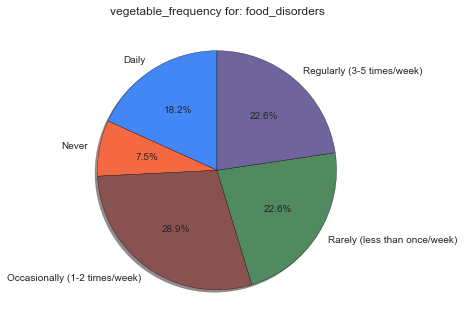

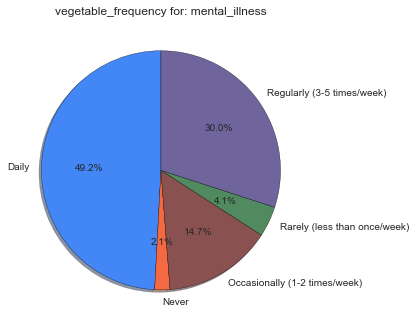

In [21]:
pie_chart(query_result_mental_food, ['food_disorders', 'mental_illness'], 'vegetable_frequency', 'mental_ill_vs_food_dis')

In [ ]:
violin(query_result_mental_food, ['food_disorders', 'mental_illness'], 'bmi', 'mental_ill_vs_food_dis')

In [5]:
mental, food = get_sample_with_top_bacteria('mental_ill_vs_food_dis', ['mental_illness', 'food_disorders'])

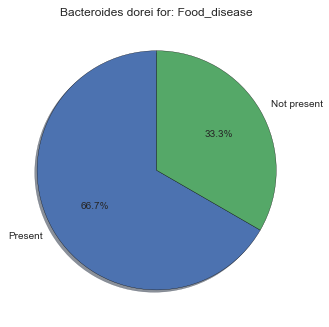

In [9]:
# Mental_illness
# Food_disease
plot_presence_on_total('Food_disease', 'Bacteroides dorei', food, 'mental_ill_vs_food_dis')

### Cancer and cardiovascular

In [ ]:
query_result_cancer_cardio = load_dataset('cancer_and_cardiovascular', ['cancer', 'cardiovascular'])

In [ ]:
pie_chart(query_result_cancer_cardio, ['cancer', 'cardiovascular'], 'diabetes', 'mental_ill_vs_food_dis')

In [ ]:
violin(query_result_cancer_cardio, ['cancer', 'cardiovascular'], 'bmi', 'cancer_and_cardiovascular')

In [10]:
cancer, cardio = get_sample_with_top_bacteria('cancer_and_cardiovascular', ['cancer', 'cardiovascular'])

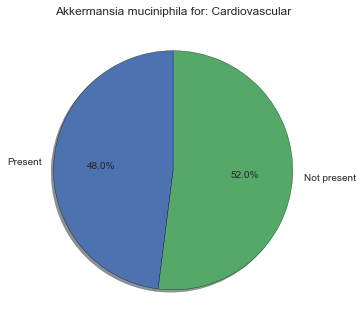

In [15]:
# Cancer
# Cardiovascular
plot_presence_on_total('Cardiovascular', 'Akkermansia muciniphila', cardio, 'cancer_and_cardiovascular')